In [1]:
import os
import json
import numpy as np
import scipy.stats as ss
import matplotlib
import pylab as plt
import pickle as pkl
from glob import glob
from copy import deepcopy

def filter_by_condi(a, mods, prs, lls, dds, mod=None, pr=None, ll=None, dd=None):
    """
    Filter a matrix of trial data to only get the data from trials that match the specified condition(s)
    :param a: A numpy array with the data from one trial on each row
    :param condi: A list of tuples indicating the list length, presentation rate, modality, distractor duration of each trial
    :param ll: Return only trials with this list length condition (ignore if None)
    :param pr: Return only trials with this presentation rate condition (ignore if None)
    :param mod: Return only trials with this presentation modality condition (ignore if None)
    :param dd: Return only trials with this distractor duration condition (ignore if None
    :return: A numpy array containing only the data from trials that match the specified condition(s)
    """
    if pr == 's':
        pr = 1600
    elif pr == 'f':
        pr = 800
        
    ll = int(ll) if ll is not None else None
    dd = int(dd) if dd is not None else None
    
    ind = [i for i in range(len(a)) if ((ll is None or lls[i] == ll) and (pr is None or prs[i] == pr) and (mod is None or mods[i] == mod) and (dd is None or dds[i] == dd))]
    if len(ind) == 0:
        return np.array([])
    return np.array(a)[ind]

In [2]:
EXCL_WN = True
COLOR = True

excl_str = '_excl_wn' if EXCL_WN else ''
if COLOR:
    VIS_COLOR = '#011F5B' #'C0-'
    AUD_COLOR = '#990000' #'C3-'
    VA_COLOR = '#990000'
    AV_COLOR = '#011F5B'
    VIS_FMT = '-'
    AUD_FMT = '-'
    VA_FMT = '--'
    AV_FMT = '--'
    ERR_ALPHA = .3
    ERR_ALPHA2 = .15
    ERR_ALPHA3 = .1
    VIS_MFC = VIS_COLOR
    AUD_MFC = AUD_COLOR
else:
    VIS_COLOR = 'k'
    AUD_COLOR = 'k'
    VA_COLOR = 'k'
    AV_COLOR = 'k'
    VIS_FMT = '-'
    AUD_FMT = '--'
    VA_FMT = '-.'
    AV_FMT = ':'
    ERR_ALPHA = .2
    ERR_ALPHA2 = .15
    ERR_ALPHA3 = .1
    VIS_MFC = VIS_COLOR
    AUD_MFC = 'w'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 18

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [3]:
###
# Load statistics and list of participants who wrote notes
###

WN = [s.decode('UTF-8') for s in np.loadtxt('../Data/WROTE_NOTES.txt', dtype='S8')]

with open('../Data/stats/all_v1%s.json' % excl_str, 'r') as f:
    s = json.load(f)

means1 = s['mean']
sems1 = s['sem']
Ns1 = s['N']

with open('../Data/stats/all_v2%s.json' % excl_str, 'r') as f:
    s = json.load(f)

means2 = s['mean']
sems2 = s['sem']
Ns2 = s['N']

In [4]:
subj_files = glob('../Data/stats/MTK[0-9][0-9][0-9][0-9].json')
subj_files = [f for f in subj_files if f[-12:-5] not in WN]

nsubj = len(subj_files)
spc = np.full((nsubj, 24, 2, 2), np.nan)  # Probability of recall for each subj x serialpos x modality x list length
pfr = np.full((nsubj, 24, 2, 2), np.nan)
spc_fr1 = np.full((nsubj, 24, 2, 2), np.nan)
spc_frl4 = np.full((nsubj, 24, 2, 2), np.nan)

for i, path in enumerate(subj_files):
    with open(path, 'r') as f:
        s = json.load(f)
    for j, mod in enumerate(('v', 'a')):
        for k, ll in enumerate(('12', '24')):
            if mod + ll in s['spc']:
                spc[i, :int(ll), j, k] = s['spc'][mod + ll]
                pfr[i, :int(ll), j, k] = s['pfr'][mod + ll]
                spc_fr1[i, :int(ll), j, k] = s['spc_fr1'][mod + ll]
                spc_frl4[i, :int(ll), j, k] = s['spc_frl4'][mod + ll]

# SPC

C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


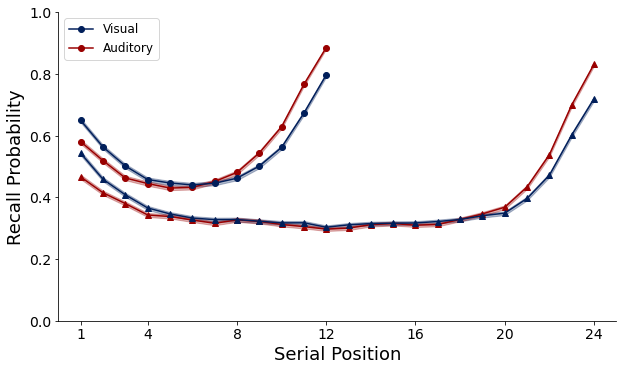

In [5]:
m = np.nanmean(spc, axis=0)
s = ss.sem(spc, axis=0, nan_policy='omit')

plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.legend(labels=['Visual', 'Auditory'], loc=2)
plt.xlabel('Serial Position')
plt.ylabel('Recall Probability')
plt.ylim(0, 1)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])
plt.gcf().set_size_inches(9, 5.5)
plt.tight_layout(w_pad=.5)
plt.savefig('poster_figures/spc.svg')

# PFR

C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


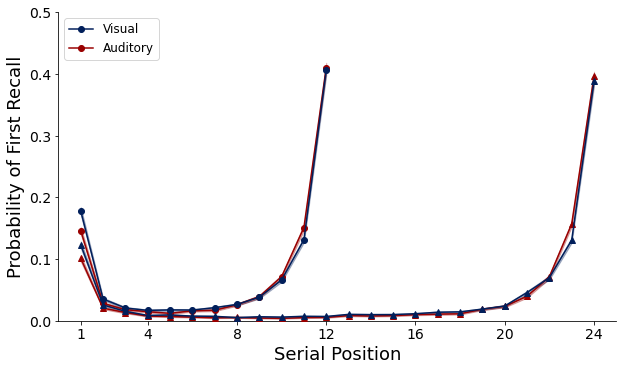

In [6]:
m = np.nanmean(pfr, axis=0)
s = ss.sem(pfr, axis=0, nan_policy='omit')

plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.legend(labels=['Visual', 'Auditory'], loc=2)
plt.xlabel('Serial Position')
plt.ylabel('Probability of First Recall')
plt.ylim(0, .5)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])
plt.gcf().set_size_inches(9, 5.5)
plt.tight_layout(w_pad=.5)
plt.savefig('poster_figures/pfr.svg')

# SPC by Start Position

C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
C:\Users\jpazd\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


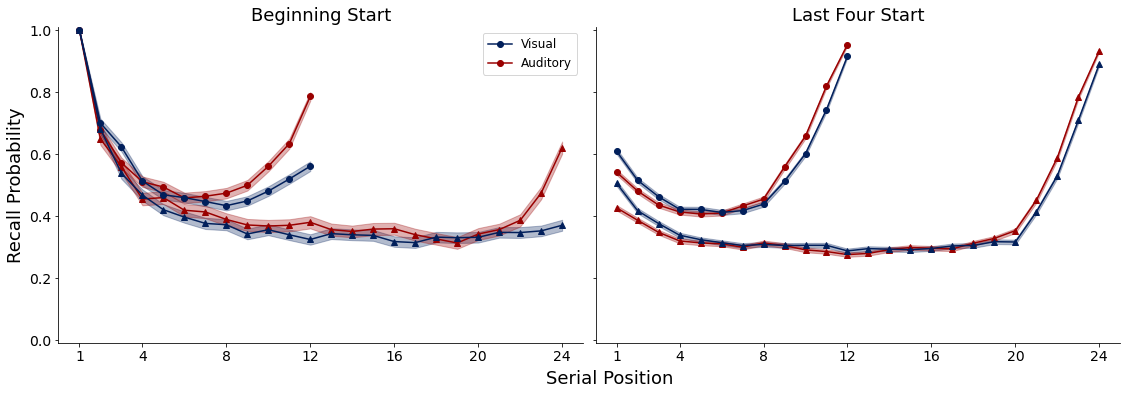

In [7]:
m = np.nanmean(spc_fr1, axis=0)
s = ss.sem(spc_fr1, axis=0, nan_policy='omit')

plt.subplot(121)
plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.legend(labels=['Visual', 'Auditory'])#, loc=2)
plt.title('Beginning Start')
plt.ylabel('Recall Probability')
plt.ylim(-.01, 1.01)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])

m = np.nanmean(spc_frl4, axis=0)
s = ss.sem(spc_frl4, axis=0, nan_policy='omit')

plt.subplot(122)
plt.plot(range(1, 13), m[:12, 0, 0], VIS_FMT+'o', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 13), m[:12, 0, 0] + s[:12, 0, 0], m[:12, 0, 0] - s[:12, 0, 0], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 13), m[:12, 1, 0], AUD_FMT+'o', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 13), m[:12, 1, 0] + s[:12, 1, 0], m[:12, 1, 0] - s[:12, 1, 0], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 0, 1], VIS_FMT+'^', color=VIS_COLOR, mfc=VIS_MFC, zorder=4)
plt.fill_between(range(1, 25), m[:, 0, 1] + s[:, 0, 1], m[:, 0, 1] - s[:, 0, 1], color=VIS_COLOR, alpha=ERR_ALPHA)
plt.plot(range(1, 25), m[:, 1, 1], AUD_FMT+'^', color=AUD_COLOR, mfc=AUD_MFC, zorder=3)
plt.fill_between(range(1, 25), m[:, 1, 1] + s[:, 1, 1], m[:, 1, 1] - s[:, 1, 1], color=AUD_COLOR, alpha=ERR_ALPHA)
plt.title('Last Four Start')
plt.ylim(-.01, 1.01)
plt.xlim(0, 25)
plt.xticks([1, 4, 8, 12, 16, 20, 24])
plt.yticks(ticks=[0, .2, .4, .6, .8, 1], labels=[])

plt.gcf().text(0.54, 0.012, 'Serial Position', ha='center', va='center')
plt.gcf().set_size_inches(16, 5.5)
plt.tight_layout(w_pad=.5)
plt.savefig('poster_figures/spc_by_start.svg')

# Prior-List Intrusions

In [8]:
def intrusions(m1, s1, m2, s2, n_points=5):
    
    f, ((sp1, sp2), (sp3, sp4)) = plt.subplots(2, 2, gridspec_kw={'width_ratios':[1, 1.4]})

    m = m1['plis_2factor']
    s = s1['plis_2factor']
    
    sp1.bar([1, 2, 3, 4], [m[0][0], m[1][1], m[0][1], m[1][0]], yerr=[s[0][0]*1.96, s[1][1]*1.96, s[0][1]*1.96, s[1][0]*1.96], color=['w', 'w', 'w', 'w'], edgecolor='k', capsize=3)
    sp1.set_xticks([1, 2, 3, 4])
    sp1.set_xticklabels(('V-V', 'A-A', 'V-A', 'A-V'))
    sp1.set_ylim(0, .125)
    sp1.set_xlabel('Modality')
    sp1.set_ylabel('PLIs per Trial (Exp. 1)')
    sp1.spines['right'].set_visible(False)
    sp1.spines['top'].set_visible(False)
    sp1.yaxis.set_ticks_position('left')
    sp1.xaxis.set_ticks_position('bottom')
    
    m = m2['plis']
    s = s2['plis']
    
    sp3.bar([1, 2], [m['v'], m['a']], yerr=[s['v']*1.96, s['a']*1.96], color=['w', 'w'], edgecolor='k', capsize=3)
    sp3.set_xticks([1, 2])
    sp3.set_xticklabels(('Visual', 'Auditory'))
    sp3.set_ylim(0, .25)
    sp3.set_xlabel('Modality')
    sp3.set_ylabel('PLIs per Trial (Exp. 2)')
    sp3.spines['right'].set_visible(False)
    sp3.spines['top'].set_visible(False)
    sp3.yaxis.set_ticks_position('left')
    sp3.xaxis.set_ticks_position('bottom')
    
    xrange = range(1, 6)
    m = np.array(m1['pli_recency_2factor'])
    s = np.array(s1['pli_recency_2factor'])
    
    sp2.plot(xrange, m[:n_points, 0, 0], VIS_FMT, color=VIS_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 0, 0], s[:n_points, 0, 0]), np.subtract(m[:n_points, 0, 0], s[:n_points, 0, 0]), color=VIS_COLOR, alpha=ERR_ALPHA)
    sp2.plot(xrange, m[:n_points, 0, 1], VA_FMT, color=VA_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 0, 1], s[:n_points, 0, 1]), np.subtract(m[:n_points, 0, 1], s[:n_points, 0, 1]), color=VA_COLOR, alpha=ERR_ALPHA)
    sp2.plot(xrange, m[:n_points, 1, 0], AV_FMT, color=AV_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 1, 0], s[:n_points, 1, 0]), np.subtract(m[:n_points, 1, 0], s[:n_points, 1, 0]), color=AV_COLOR, alpha=ERR_ALPHA)
    sp2.plot(xrange, m[:n_points, 1, 1], AUD_FMT, color=AUD_COLOR)
    sp2.fill_between(xrange, np.add(m[:n_points, 1, 1], s[:n_points, 1, 1]), np.subtract(m[:n_points, 1, 1], s[:n_points, 1, 1]), color=AUD_COLOR, alpha=ERR_ALPHA)
    sp2.legend(labels=['V-V', 'V-A', 'A-V', 'A-A'])
    sp2.set_xlabel('List Recency')
    sp2.set_ylabel('Proportion of PLIs (Exp. 1)')
    sp2.set_xticks(xrange)
    sp2.set_ylim(0, .5)
    sp2.spines['right'].set_visible(False)
    sp2.spines['top'].set_visible(False)
    sp2.yaxis.set_ticks_position('left')
    sp2.xaxis.set_ticks_position('bottom')
    
    m = m2['pli_recency']
    s = s2['pli_recency']
    
    sp4.plot(xrange, m['v'][:n_points], VIS_FMT, color=VIS_COLOR)
    sp4.fill_between(xrange, np.add(m['v'][:n_points], s['v'][:n_points]), np.subtract(m['v'][:n_points], s['v'][:n_points]), color=VIS_COLOR, alpha=ERR_ALPHA)
    sp4.plot(xrange, m['a'][:n_points], AUD_FMT, color=AUD_COLOR)
    sp4.fill_between(xrange, np.add(m['a'][:n_points], s['a'][:n_points]), np.subtract(m['a'][:n_points], s['a'][:n_points]), color=AUD_COLOR, alpha=ERR_ALPHA)
    sp4.legend(labels=['Visual', 'Auditory'])
    sp4.set_xlabel('List Recency')
    sp4.set_ylabel('Proportion of PLIs (Exp. 2)')
    sp4.set_xticks(xrange)
    sp4.set_ylim(0, .5)
    sp4.spines['right'].set_visible(False)
    sp4.spines['top'].set_visible(False)
    sp4.yaxis.set_ticks_position('left')
    sp4.xaxis.set_ticks_position('bottom')
    
    plt.gcf().set_size_inches(12, 10)
    plt.tight_layout(w_pad=.5)

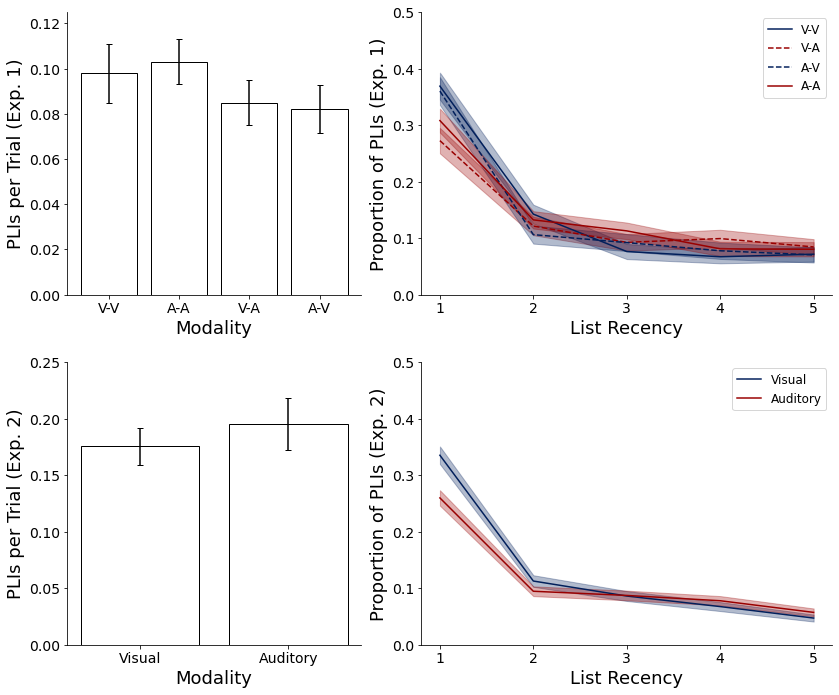

In [9]:
intrusions(means1, sems1, means2, sems2)
plt.savefig('poster_figures/intrusions.svg')

# Simulation Figures

In [10]:
def plot_sim2(vis, aud, vis_sim, aud_sim, xticks=None):

    plt.figure(figsize=(12, 10))
    
    # SPC Data
    ax=plt.subplot(3, 2, 1)
    plt.title('Data')
    for ll in vis['spc']:
        plt.plot(range(1, int(ll)+1), np.array(vis['spc'][ll]), VIS_FMT, c=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), np.array(aud['spc'][ll]), AUD_FMT, c=AUD_COLOR)
        if ll != '6':
            plt.fill_between(range(1, int(ll)+1), np.add(vis['spc'][ll], vis['spc_sem'][ll]), np.subtract(vis['spc'][ll], vis['spc_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
            plt.fill_between(range(1, int(ll)+1), np.add(aud['spc'][ll], aud['spc_sem'][ll]), np.subtract(aud['spc'][ll], aud['spc_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Recall Prob.')
    plt.ylim(0, 1)
    plt.legend(['Visual', 'Auditory'])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # SPC Model
    ax=plt.subplot(3, 2, 2)
    plt.title('Model')
    for ll in vis_sim['spc']:
        plt.plot(range(1, int(ll)+1), np.array(vis_sim['spc'][ll]), VIS_FMT, c=VIS_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(vis_sim['spc'][ll], vis_sim['spc_sem'][ll]), np.subtract(vis_sim['spc'][ll], vis_sim['spc_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), np.array(aud_sim['spc'][ll]), AUD_FMT, c=AUD_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(aud_sim['spc'][ll], aud_sim['spc_sem'][ll]), np.subtract(aud_sim['spc'][ll], aud_sim['spc_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Recall Prob.')
    plt.ylim(0, 1)
    plt.legend(['Visual', 'Auditory'])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # SPC (FR=SP1) Data
    ax=plt.subplot(3, 2, 3)
    for ll in vis['spc_fr1']:
        plt.plot(range(1, int(ll)+1), vis['spc_fr1'][ll], VIS_FMT, c=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), aud['spc_fr1'][ll], AUD_FMT, c=AUD_COLOR)
        if ll != '6':
            plt.fill_between(range(1, int(ll)+1), np.add(vis['spc_fr1'][ll], vis['spc_fr1_sem'][ll]), np.subtract(vis['spc_fr1'][ll], vis['spc_fr1_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
            plt.fill_between(range(1, int(ll)+1), np.add(aud['spc_fr1'][ll], aud['spc_fr1_sem'][ll]), np.subtract(aud['spc_fr1'][ll], aud['spc_fr1_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.ylim(-.01, 1.01)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Recall Prob. (SP1)')
    plt.ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # SPC (FR=SP1) Model
    ax=plt.subplot(3, 2, 4)
    for ll in vis_sim['spc_fr1']:
        plt.plot(range(1, int(ll)+1), vis_sim['spc_fr1'][ll], VIS_FMT, c=VIS_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(vis_sim['spc_fr1'][ll], vis_sim['spc_fr1_sem'][ll]), np.subtract(vis_sim['spc_fr1'][ll], vis_sim['spc_fr1_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), aud_sim['spc_fr1'][ll], AUD_FMT, c=AUD_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(aud_sim['spc_fr1'][ll], aud_sim['spc_fr1_sem'][ll]), np.subtract(aud_sim['spc_fr1'][ll], aud_sim['spc_fr1_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.ylim(-.01, 1.01)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Recall Prob. (SP1)')
    plt.ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # SPC (FR=L4) Data
    ax=plt.subplot(3, 2, 5)
    for ll in vis['spc_frl4']:
        plt.plot(range(1, int(ll)+1), vis['spc_frl4'][ll], VIS_FMT, c=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), aud['spc_frl4'][ll], AUD_FMT, c=AUD_COLOR)
        if ll != '6':
            plt.fill_between(range(1, int(ll)+1), np.add(vis['spc_frl4'][ll], vis['spc_frl4_sem'][ll]), np.subtract(vis['spc_frl4'][ll], vis['spc_frl4_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
            plt.fill_between(range(1, int(ll)+1), np.add(aud['spc_frl4'][ll], aud['spc_frl4_sem'][ll]), np.subtract(aud['spc_frl4'][ll], aud['spc_frl4_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.ylim(-.01, 1.01)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Recall Prob. (L4)')
    plt.ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # SPC (FR=L4) Model
    ax=plt.subplot(3, 2, 6)
    for ll in vis_sim['spc_frl4']:
        plt.plot(range(1, int(ll)+1), vis_sim['spc_frl4'][ll], VIS_FMT, c=VIS_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(vis_sim['spc_frl4'][ll], vis_sim['spc_frl4_sem'][ll]), np.subtract(vis_sim['spc_frl4'][ll], vis_sim['spc_frl4_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), aud_sim['spc_frl4'][ll], AUD_FMT, c=AUD_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(aud_sim['spc_frl4'][ll], aud_sim['spc_frl4_sem'][ll]), np.subtract(aud_sim['spc_frl4'][ll], aud_sim['spc_frl4_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.ylim(-.01, 1.01)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Recall Prob. (L4)')
    plt.ylim(0, 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    plt.tight_layout(h_pad=-.05)


def plot_sim2_nonspc(vis, aud, vis_sim, aud_sim, xticks=None):
    
    plt.figure(figsize=(12, 10))
    
    # PFR Data
    ax=plt.subplot(321)
    plt.title('Data')
    for ll in vis['pfr']:
        plt.plot(range(1, int(ll)+1), vis['pfr'][ll], VIS_FMT, c=VIS_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(vis['pfr'][ll], vis['pfr_sem'][ll]), np.subtract(vis['pfr'][ll], vis['pfr_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), aud['pfr'][ll], AUD_FMT, c=AUD_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(aud['pfr'][ll], aud['pfr_sem'][ll]), np.subtract(aud['pfr'][ll], aud['pfr_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Prob. of First Recall')
    plt.legend(['Visual', 'Auditory'])
    plt.ylim(0, .5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # PFR Model
    ax=plt.subplot(322)
    plt.title('Model')
    for ll in vis_sim['pfr']:
        plt.plot(range(1, int(ll)+1), vis_sim['pfr'][ll], VIS_FMT, c=VIS_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(vis_sim['pfr'][ll], vis_sim['pfr_sem'][ll]), np.subtract(vis_sim['pfr'][ll], vis_sim['pfr_sem'][ll]), alpha=ERR_ALPHA, color=VIS_COLOR)
        plt.plot(range(1, int(ll)+1), aud_sim['pfr'][ll], AUD_FMT, c=AUD_COLOR)
        plt.fill_between(range(1, int(ll)+1), np.add(aud_sim['pfr'][ll], aud_sim['pfr_sem'][ll]), np.subtract(aud_sim['pfr'][ll], aud_sim['pfr_sem'][ll]), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.xticks(xticks)
    plt.xlabel('Serial Position')
    plt.ylabel('Prob. of First Recall')
    plt.legend(['Visual', 'Auditory'], loc=2)
    plt.ylim(0, .5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # PLIs Data
    ax=plt.subplot(323)
    plt.bar([1, 1.75], [vis['plis'], aud['plis']], yerr=[vis['plis_sem']*1.96, aud['plis_sem']*1.96], color=[VIS_COLOR, AUD_COLOR], ec='k', width=.5, capsize=3, alpha=.5)
    plt.xlim(.5, 2.25)
    plt.xticks([1, 1.75], ['Visual', 'Auditory'])
    plt.xlabel('Modality')
    plt.ylabel('PLIs per Trial')
    plt.ylim(0, .3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # PLIs Model
    ax=plt.subplot(324)
    plt.bar([1, 1.75], [vis_sim['plis'], aud_sim['plis']], yerr=[vis_sim['plis_sem']*1.96, aud_sim['plis_sem']*1.96], color=[VIS_COLOR, AUD_COLOR], ec='k', width=.5, capsize=3, alpha=.5)
    plt.xlim(.5, 2.25)
    plt.xticks([1, 1.75], ['Visual', 'Auditory'])
    plt.xlabel('Modality')
    plt.ylabel('PLIs per Trial')
    plt.ylim(0, .3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # PLI Recency Data
    ax=plt.subplot(325)
    plt.plot(range(1, 6), vis['pli_recency'], VIS_FMT, c=VIS_COLOR)
    plt.fill_between(range(1, 6), np.add(vis['pli_recency'], vis['pli_recency_sem']), np.subtract(vis['pli_recency'], vis['pli_recency_sem']), alpha=ERR_ALPHA, color=VIS_COLOR)
    plt.plot(range(1, 6), aud['pli_recency'], AUD_FMT, c=AUD_COLOR)
    plt.fill_between(range(1, 6), np.add(aud['pli_recency'], aud['pli_recency_sem']), np.subtract(aud['pli_recency'], aud['pli_recency_sem']), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.xlabel('List Recency')
    plt.ylabel('Proportion of PLIs')
    plt.legend(['Visual', 'Auditory'])
    plt.ylim(0, .5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # PLI Recency Model
    ax=plt.subplot(326)
    plt.plot(range(1, 6), vis_sim['pli_recency'], VIS_FMT, c=VIS_COLOR)
    plt.fill_between(range(1, 6), np.add(vis_sim['pli_recency'], vis_sim['pli_recency_sem']), np.subtract(vis_sim['pli_recency'], vis_sim['pli_recency_sem']), alpha=ERR_ALPHA, color=VIS_COLOR)
    plt.plot(range(1, 6), aud_sim['pli_recency'], AUD_FMT, c=AUD_COLOR)
    plt.fill_between(range(1, 6), np.add(aud_sim['pli_recency'], aud_sim['pli_recency_sem']), np.subtract(aud_sim['pli_recency'], aud_sim['pli_recency_sem']), alpha=ERR_ALPHA, color=AUD_COLOR)
    plt.xlabel('List Recency')
    plt.ylabel('Proportion of PLIs')
    plt.legend(['Visual', 'Auditory'])
    plt.ylim(0, .5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    plt.tight_layout(h_pad=-.05)

In [11]:
with open('../Modeling/CMR2/target_stats_sim2a_v.json', 'r') as f:
    dva = json.load(f)
    
with open('../Modeling/CMR2/target_stats_sim2a_a.json', 'r') as f:
    daa = json.load(f)

with open('../Modeling/CMR2/sim2a_results.pkl', 'rb') as f:
    m = pkl.load(f)
    mva = m[np.argmin([x['err_spc_composite_v'] for x in m])]
    maa = m[np.argmin([x['err_spc_composite_a'] for x in m])]
    

all_dv = deepcopy(dva)
all_da = deepcopy(daa)
all_mv = deepcopy(mva)
all_ma = deepcopy(maa)


with open('../Modeling/CMR2/target_stats_sim2b_v.json', 'r') as f:
    dvb = json.load(f)
    
with open('../Modeling/CMR2/target_stats_sim2b_a.json', 'r') as f:
    dab = json.load(f)

with open('../Modeling/CMR2/sim2b_results.pkl', 'rb') as f:
    m = pkl.load(f)
    mvb = m[np.argmin([x['err_spc_composite_v'] for x in m])]
    mab = m[np.argmin([x['err_spc_composite_a'] for x in m])]
    
    
for key in ('spc', 'spc_fr1', 'spc_frl4', 'spc_sem', 'spc_fr1_sem', 'spc_frl4_sem'):
    if key in dvb and '24' in dvb[key]:
        all_dv[key]['24'] = dvb[key]['24']
        all_da[key]['24'] = dab[key]['24']
    if key in mvb and '24' in mvb[key]:
        all_mv[key]['24'] = mvb[key]['24']
        all_ma[key]['24'] = mab[key]['24']

   
with open('../Modeling/CMR2/target_stats_sim2c_v.json', 'r') as f:
    dvc = json.load(f)
    
with open('../Modeling/CMR2/target_stats_sim2c_a.json', 'r') as f:
    dac = json.load(f)

with open('../Modeling/CMR2/sim2c_results.pkl', 'rb') as f:
    m = pkl.load(f)
    mvc = m[np.argmin([x['err_spc_composite_v'] for x in m])]
    mac = m[np.argmin([x['err_spc_composite_a'] for x in m])]
    
"""
for key in ('spc', 'spc_fr1', 'spc_frl4', 'spc_sem', 'spc_fr1_sem', 'spc_frl4_sem'):
    if key in dvc and '6' in dvc[key]:
        all_dv[key]['6'] = dvc[key]['6']
        all_da[key]['6'] = dac[key]['6']
    if key in mvc and '6' in mv[key]:
        all_mv[key]['6'] = mvc[key]['6']
        all_ma[key]['6'] = mac[key]['6']
"""
pass

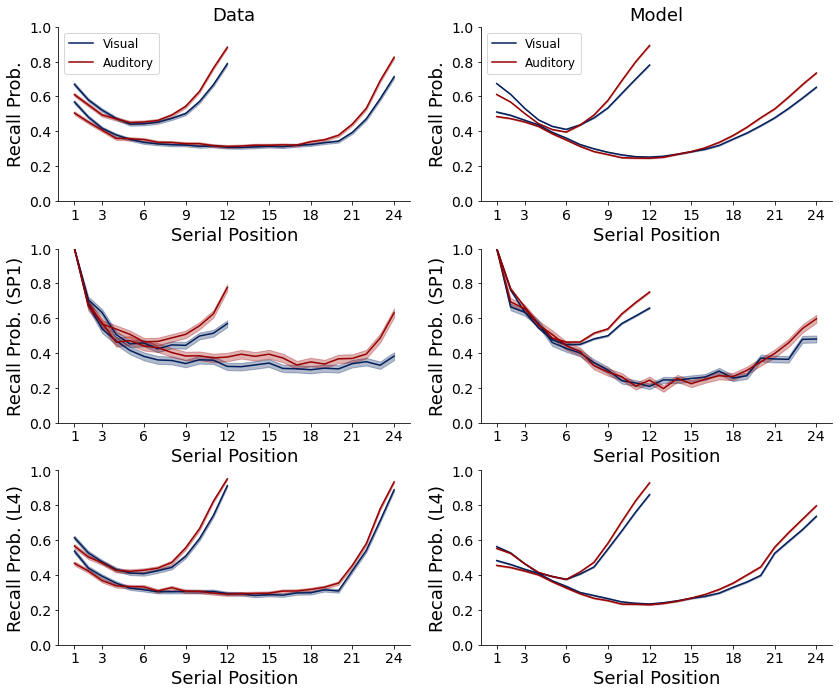

In [12]:
plot_sim2(all_dv, all_da, all_mv, all_ma, xticks=[1, 3, 6, 9, 12, 15, 18, 21, 24])
plt.gcf().savefig('poster_figures/modality_sim.svg')

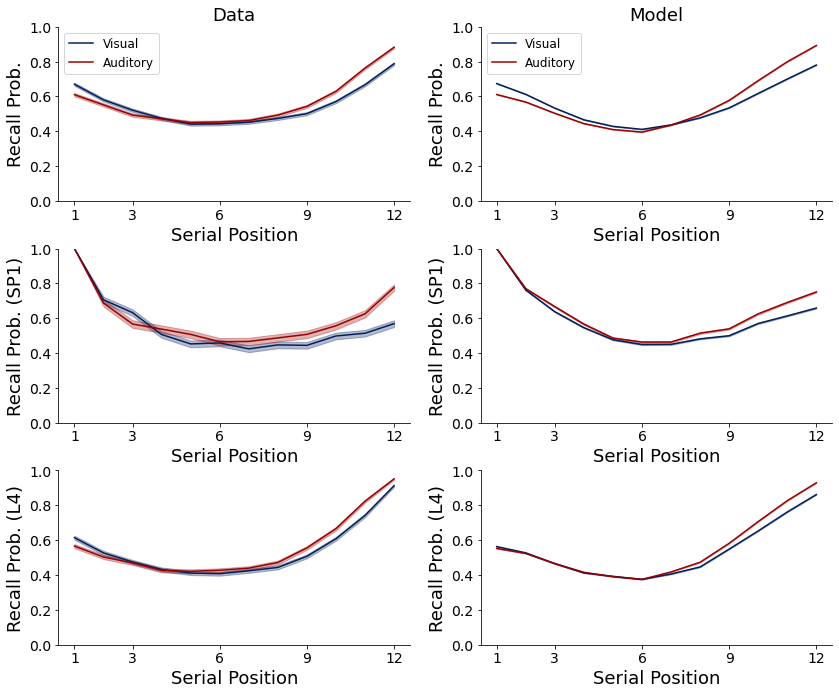

In [13]:
plot_sim2(dva, daa, mva, maa, xticks=[1, 3, 6, 9, 12])
plt.gcf().savefig('poster_figures/sim2a_spcs.svg')

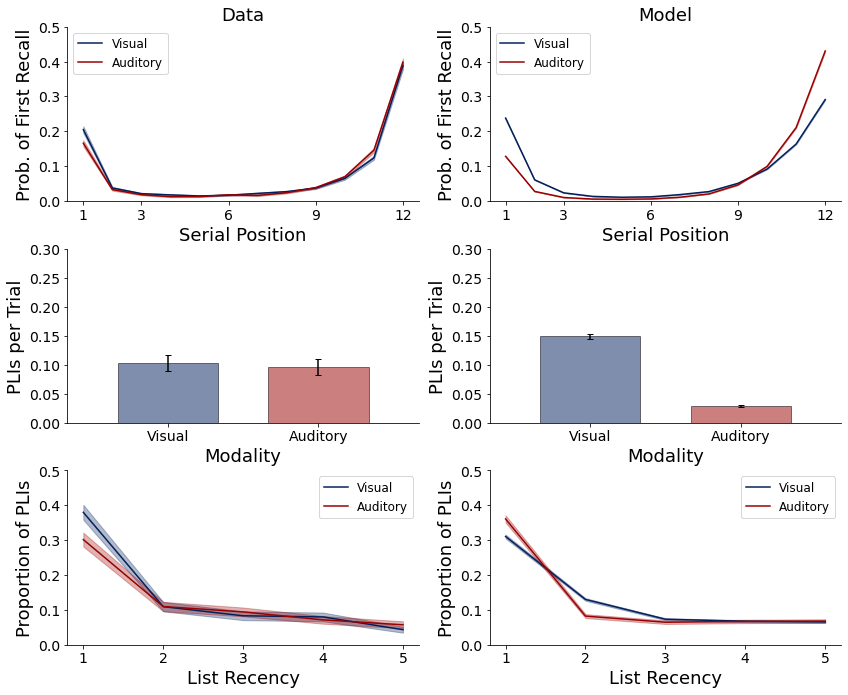

In [14]:
plot_sim2_nonspc(dva, daa, mva, maa, xticks=[1, 3, 6, 9, 12])
plt.gcf().savefig('poster_figures/sim2a_nonspc.svg')

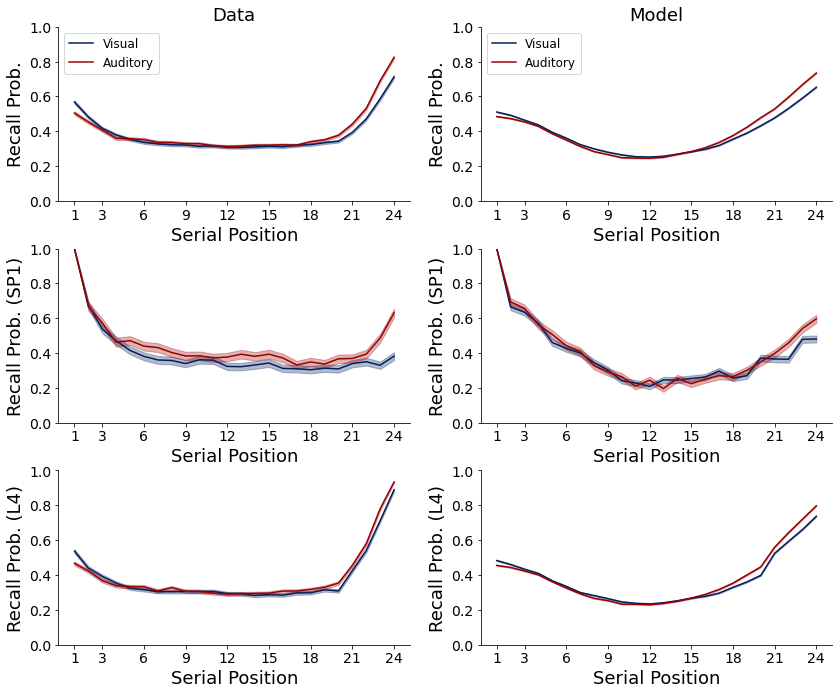

In [15]:
plot_sim2(dvb, dab, mvb, mab, xticks=[1, 3, 6, 9, 12, 15, 18, 21, 24])
plt.gcf().savefig('poster_figures/sim2b_spcs.svg')

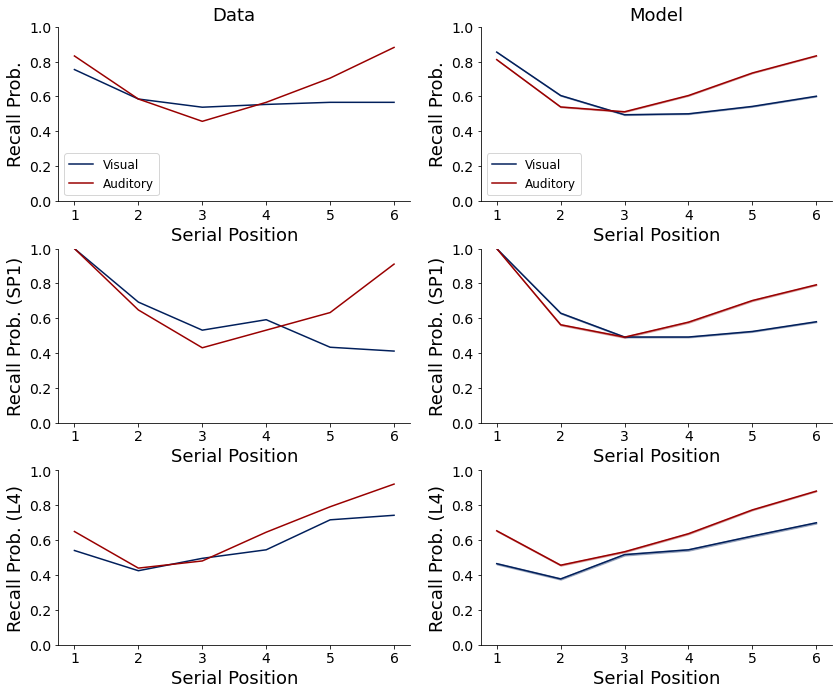

In [16]:
plot_sim2(dvc, dac, mvc, mac, xticks=range(1, 7))
plt.gcf().savefig('poster_figures/sim2c_spcs.svg')